In [1]:
import numpy as np
import tensorflow as tf
from tensorflow_probability import edward2 as ed
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
NSAMPLE = 5
NSAMPLETEST = 10000
prior_scale = 0.01
seed = 1
lr = 0.005
num_epochs = 1000
verbose = True
Ts = [0.1, 1.0, 10.0, 100.0, 1000.0]

MODEL_MISSSPECIFICATION = True
if MODEL_MISSSPECIFICATION:
    VAR = 0.01
else:
    VAR = 1.0

In [3]:
def sampleData(samples, variance):
    x = np.linspace(-10.5, 10.5, samples).reshape(-1, 1)
    r = 1 + np.float32(np.random.normal(size=(samples, 1), scale=variance))
    y = np.float32(x * 1.0 + r * 1.0)
    return (x, y)


def model(NSAMPLE):
    W = ed.MultivariateNormalTriL(
        tf.zeros([1, 2]), tf.zeros([2, 2]) + tf.eye(2) * prior_scale, name="W"
    )
    x = ed.Normal(loc=tf.zeros([NSAMPLE, 1]), scale=1.0, name="x")

    out = tf.matmul(x, W)[:, 0] + tf.matmul(tf.ones(x.shape), W)[:, 1]
    out = tf.expand_dims(out, 1)
    y = ed.Normal(loc=out, scale=1.0, name="y")
    return W, x, y


def qmodel():
    qmu0 = tf.Variable(tf.random_normal([1, 2], 0.0, 0.05, dtype=tf.float32))
    qR = tf.Variable(tf.random_normal([2, 2], 0.0, stddev=0.05, dtype=tf.float32))
    qW = ed.MultivariateNormalTriL(qmu0, qR, name="W")
    return qW

In [4]:
np.random.seed(seed)
tf.set_random_seed(seed)

(x_train, y_train) = sampleData(NSAMPLE, VAR)
(x_test, y_test) = sampleData(NSAMPLETEST, VAR)

# plt.scatter(x_train, y_train, marker='+', label='Training data')
# plt.ylim(-20,20)
# plt.xticks(np.arange(-10.5, 10.5, 4))
# plt.legend()
# plt.show()

# plt.scatter(x_test, y_test, marker='+', label='Test data')
# plt.ylim(-20,20)
# plt.xticks(np.arange(-10.5, 10.5, 4))
# plt.legend()
# plt.show()

/home/nsq277/miniconda3/envs/cpe_pacbayes_vi_tf/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  if __name__ == '__main__':


.
0 epochs	77.18208..........
100 epochs	29.74611..........
200 epochs	29.652088..........
300 epochs	28.635668..........
400 epochs	30.196585..........
500 epochs	30.24585..........
600 epochs	31.486418..........
700 epochs	29.715584..........
800 epochs	28.258663..........
900 epochs	30.372124..........
1000 epochs	29.812508

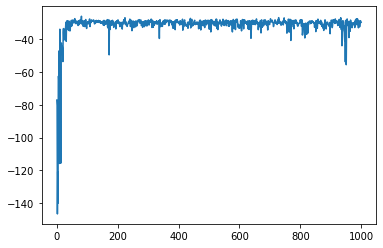

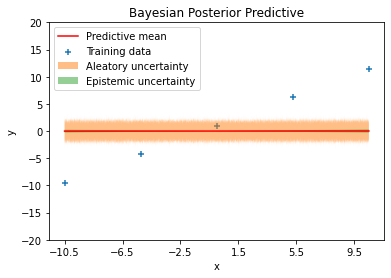

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

 lamb: 0.1, nll: 194297.859375
.
0 epochs	39.13199..........
100 epochs	28.263124..........
200 epochs	28.271053..........
300 epochs	28.417925..........
400 epochs	28.271791..........
500 epochs	28.287443..........
600 epochs	28.310797..........
700 epochs	28.265574..........
800 epochs	28.347612..........
900 epochs	28.243351..........
1000 epochs	28.281181

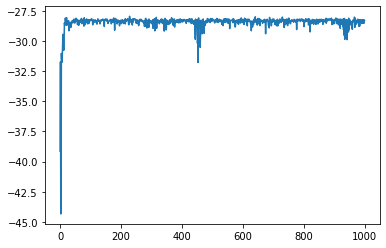

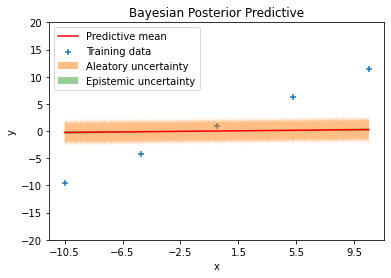


 lamb: 1.0, nll: 186257.96875
.
0 epochs	30.27985..........
100 epochs	23.032085..........
200 epochs	23.019753..........
300 epochs	23.00932..........
400 epochs	23.01657..........
500 epochs	23.01989..........
600 epochs	23.018534..........
700 epochs	23.011469..........
800 epochs	23.050346..........
900 epochs	23.007084..........
1000 epochs	23.014393

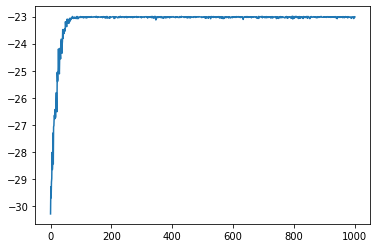

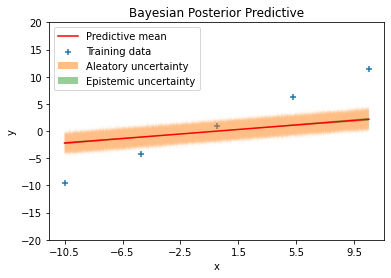


 lamb: 10.0, nll: 127144.1328125
.
0 epochs	34.05581..........
100 epochs	13.570208..........
200 epochs	8.979288..........
300 epochs	8.740238..........
400 epochs	8.730257..........
500 epochs	8.729658..........
600 epochs	8.730392..........
700 epochs	8.730009..........
800 epochs	8.72933..........
900 epochs	8.733519..........
1000 epochs	8.728236

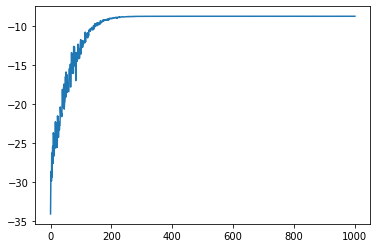

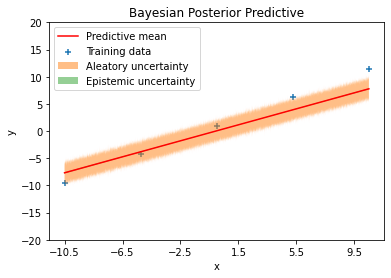


 lamb: 100.0, nll: 26622.61328125
.
0 epochs	29.486506..........
100 epochs	9.634039..........
200 epochs	3.5493028..........
300 epochs	2.3730726..........
400 epochs	2.229473..........
500 epochs	2.2187324..........
600 epochs	2.2174087..........
700 epochs	2.2172732..........
800 epochs	2.2173562..........
900 epochs	2.2172456..........
1000 epochs	2.2174823

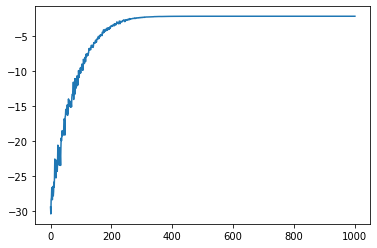

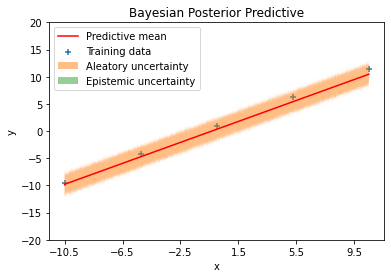


 lamb: 1000.0, nll: 11632.671875


In [5]:
nlls = []
for lamb in Ts:
    ## Control the presence of model miss-specficication as shown in Figures 2 and 3.

    # Set seeds for reproducibility

    W, x, y = model(NSAMPLE)

    qW = qmodel()
    qW2 = qmodel()
    qW3 = qmodel()

    with ed.interception(ed.make_value_setter(W=qW, x=x_train, y=y_train)):
        pW, px, py = model(NSAMPLE)
    with ed.interception(ed.make_value_setter(W=qW2, x=x_train, y=y_train)):
        pW2, px2, py2 = model(NSAMPLE)
    with ed.interception(ed.make_value_setter(W=qW3, x=x_train, y=y_train)):
        pW3, px3, py3 = model(NSAMPLE)

    datalikelihood = tf.reduce_mean(py.distribution.log_prob(py.value))
    datalikelihood += tf.reduce_mean(py2.distribution.log_prob(py2.value))
    datalikelihood += tf.reduce_mean(py3.distribution.log_prob(py3.value))
    datalikelihood /= 3

    KL = tf.reduce_sum(qW.distribution.log_prob(qW.value)) - tf.reduce_sum(
        pW.distribution.log_prob(pW.value)
    )
    KL += tf.reduce_sum(qW2.distribution.log_prob(qW2.value)) - tf.reduce_sum(
        pW2.distribution.log_prob(pW2.value)
    )
    KL += tf.reduce_sum(qW3.distribution.log_prob(qW3.value)) - tf.reduce_sum(
        pW3.distribution.log_prob(pW3.value)
    )
    KL /= 3

    elbo = datalikelihood - KL / (lamb * NSAMPLE)

    sess = tf.Session()
    optimizer = tf.train.AdamOptimizer(lr)
    t = []
    train = optimizer.minimize(-elbo)
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(num_epochs + 1):
        t.append(sess.run(elbo))
        sess.run(train)
        if verbose:
            if i % 10 == 0:
                print(".", end="", flush=True)
            if i % 100 == 0:
                str_elbo = str(-t[-1])
                print("\n" + str(i) + " epochs\t" + str_elbo, end="", flush=True)

    plt.plot(t)
    plt.savefig(f"loss_elbo_{lamb}.png")
    plt.show()

    with ed.interception(ed.make_value_setter(W=qW, x=x_test)):
        pW, px, py = model(NSAMPLETEST)

    # plt.figure(figsize=(8, 8))
    y_pred_list = []
    y_pred_noise = []

    for i in range(20):
        [mean, noise] = sess.run([py.distribution.mean(), py])
        y_pred_list.append(mean)
        y_pred_noise.append(noise)

    y_preds = np.concatenate(y_pred_list, axis=1)
    y_preds_noise = np.concatenate(y_pred_noise, axis=1)

    y_mean = np.mean(y_preds, axis=1)
    y_sigma = np.std(y_preds, axis=1)

    y_sigma_noise = np.std(y_preds_noise, axis=1)

    plt.plot(x_test, y_mean, "r-", label="Predictive mean")
    plt.scatter(x_train, y_train, marker="+", label="Training data")
    plt.fill_between(
        x_test.ravel(),
        y_mean + 2 * y_sigma_noise,
        y_mean - 2 * y_sigma_noise,
        alpha=0.5,
        label="Aleatory uncertainty",
    )

    plt.fill_between(
        x_test.ravel(),
        y_mean + 2 * y_sigma,
        y_mean - 2 * y_sigma,
        alpha=0.5,
        label="Epistemic uncertainty",
    )

    plt.ylabel("y")
    plt.xlabel("x")

    plt.ylim(-20, 20)
    plt.xticks(np.arange(-10.5, 10.5, 4))
    plt.legend()

    plt.title("Bayesian Posterior Predictive")
    plt.savefig(f"fit_elbo_{lamb}.png")
    plt.show()

    y_pred_list = []
    for i in range(20):
        y_pred_list.append(sess.run(py.distribution.log_prob(y_test)))

    y_preds = tf.concat(y_pred_list, axis=1)

    score = -(tf.reduce_sum(tf.math.reduce_logsumexp(y_preds, axis=1) - tf.log(20.0)))

    score = sess.run(score)
    nlls.append(score)
    print(f"\n lamb: {lamb}, nll: {score}")


In [6]:
print(nlls)

[194297.86, 186257.97, 127144.13, 26622.613, 11632.672]
